# Color Object Detection using OpenCV

### What We'll Do
We’ll explore how to use the OpenCV library for basic computer vision tasks
focusing on detecting objects in images based on their color.

To set up the python notebook run the next cell and then click install (it might take a while)

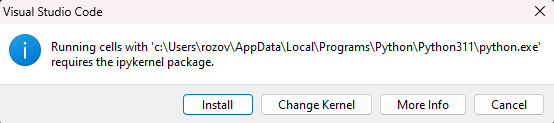

In [1]:
print("Hello World")

Hello World


### Import all necessary libraries

In [2]:
import cv2 # cv2 -> Imports open-cv our computer vision library
import numpy as np # Import the library numpy, and shorten it's name to np

### Defining the Color Range

First, we need to define our color range. The color range is in the **HSV** format: Hue, Saturation, Value.

If you don't remember what the HSV color format is, please refer to the [RaspberryPiAlgorithmOverview](https://docs.google.com/presentation/d/1yrU-Dv-jRNRMyOsbtqIMjXC6S4zTtdYh/edit?usp=sharing&ouid=106914480700002256916&rtpof=true&sd=true) presentation.

In [3]:
# The low bounds, [h, s, v]
low_bounds = np.array([4, 35, 0])
# The top bounds, [h, s, v]
top_bounds = np.array([31, 255, 255])

### Loading an Image

To start working, we first need an image. For now, we will load a given image instead of using any cameras to capture a new one.

Here is how it is done:


In [4]:
# Notes.png is the path to our image
image = cv2.imread("Notes.png")

Let's display our image to see what we are working with

In [5]:
# Parameters: Name (can be anything), The actual image
cv2.imshow("Note Image", image)

# Used to close the window when done
cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
original_image = image.copy()

### Detecting the Object in the Given Image

Now we want to detect our object in the given image.

1. **Convert Image to HSV Color Format**  
   First, we need to convert our image (which uses the RGB color format) to HSV color format:

In [7]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

2. **Create a Mask**  
   A mask is an image (2d array) that holds `True` (white) and `False` (black) values for each pixel. `True` if the pixel is inside our range and `False` otherwise

In [8]:
mask = cv2.inRange(hsv, low_bounds, top_bounds)

3. **Display the mask**  
   Lets display our original image and the mask to the screen and see if it is correct, we should see that every orange pixel in the image is colored white in the mask

In [9]:
cv2.imshow("Original Image", image)
cv2.imshow("Mask", mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Noise Reduction in the Mask

As we can clearly see, this is far from perfect. We get something that we call "noise" everywhere — those very small clumps of pixels that we, as humans, can clearly tell aren't part of the object.

We will use two built-in operations: **Morphological Opening** and **Morphological Closing**. Each one of these functions takes two parameters as input: the image and the "kernel". The kernel is the matrix (A rectangle) that defines the neighborhood used for the morphological operations. 

More info can be found here [OpenCV Morphological Operations Tutorial](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)

Below, you can see images that demonstrate what the morphological operations are doing:

Morphological Opening

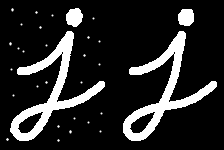

Morphological Closing

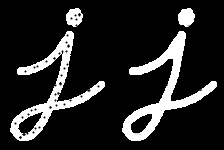

### Understanding the Kernel

The "kernel" is like a small window that we move over the image to look at one tiny part at a time. Imagine you have a magnifying glass, and you're moving it over a picture to see different small sections of the picture. The kernel helps the computer decide how to clean up or change the image by looking at these small sections. It helps in smoothing out the noise and making the important parts of the image stand out.
The kernel is essentially a small rectangle of pixels that the computer looks at

### This is how it's done in code:

In [10]:
# Define the kernel for the morphological operation
# It is a 7*7 2d array of ones
# Try changing the size of the kernel to see how it affects the image
kernel = np.ones((7, 7), np.uint8)
print(kernel)

# Perform morphological opening to remove noise
opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

# Perform morphological closing to close small holes
processed_mask = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)

[[1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1]]


Let's see the difference

In [11]:
cv2.imshow("Mask", mask)
cv2.imshow("Processed Mask", processed_mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Detecting Contours

Much better!

Now that we know which pixels are part of our object, let's do something useful with this information.

We will use the built-in function `findContours`, which will enclose our pixels inside a contour.

In this example I use `cv2.CHAIN_APPROX_NONE` this is for better visualization, when we want better performance we will use `cv.CHAIN_APPROX_SIMPLE`

More info can be found here: [OpenCv Contours](https://docs.opencv.org/3.4/d4/d73/tutorial_py_contours_begin.html)

In [12]:
contours, _ = cv2.findContours(processed_mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) # Try to change cv2.CHAIN_APPROX_NONE to cv2.CHAIN_APPROX_SIMPLE

# Draw the contours on the image
for contour in contours:
    cv2.drawContours(image, contour, -1, (0, 255, 0), 2)

cv2.imshow("Image", image)
cv2.imshow("Processed Mask", processed_mask)

cv2.waitKey(0)
cv2.destroyAllWindows()

### Addressing False Positives in Detection

Now we notice a problem: the orange electrical line at the side of the field is being detected.

**How can we help the program tell apart a game object from other orange things in the background?**

Here is one solution:

Notice that every game object has two contours: the inside one and the outside one. The program will consider a contour to be the outside contour of a game object only if it encloses another contour.

In [13]:
# We will first find a rectangle for each contour that encloses it
bounding_rectangles = []

for contour in contours:
    bounding_rectangles.append(cv2.boundingRect(contour))

# Function to check if one rectangle is inside another
def is_rectangle_inside(outer, inner):
    # Each cv2 rectangle uses the following format:
    # Python tuple (top left point x, top left point y, rectangle width, rectangle height)
    x1_outer, y1_outer, w_outer, h_outer = outer
    x1_inner, y1_inner, w_inner, h_inner = inner

    x2_outer, y2_outer = x1_outer + w_outer, y1_outer + h_outer
    x2_inner, y2_inner = x1_inner + w_inner, y1_inner + h_inner

    return x1_outer < x1_inner < x2_inner < x2_outer and y1_outer < y1_inner < y2_inner < y2_outer

# Filter contours to find those whose bounding rectangles enclose another rectangle
filtered_contours = []
for i, outer_rect in enumerate(bounding_rectangles):
    for j, inner_rect in enumerate(bounding_rectangles):
        if i != j and is_rectangle_inside(outer_rect, inner_rect):
            filtered_contours.append(contours[i])
            break


# Draw filtered contours on the image
image = original_image.copy()
for contour in filtered_contours:
    cv2.drawContours(image, contour, -1, (0, 255, 0), 2)


# Display the output image
cv2.imshow('Contours with Inner Rectangles', image)
cv2.waitKey(0)
cv2.destroyAllWindows()


### Improving the Detection

It's not perfect, but for almost all cases, it is good enough.

**Now here is your challenge:**
Make it better!

**Here are some tips:**

- Try thinking outside the box and experiment with different approaches. For example, OpenCV has a function that can find an ellipse that is close to your contour.
- First, think of an idea. Don't worry about how to implement it in code right away.
- Think of an approach and then use ChatGPT to help you with the code. Don't ask it to solve the problem for you—ask it to help you code *your* solution.

When finished, publish your branch with your solution. Make sure you understand every single line of code ChatGPT gives you. If you don't understand something, remember that ChatGPT or a Google search can usually explain it.

In [14]:
# Your code here